In [22]:
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rcParams
plt.rcParams['xtick.labelsize']  = 18
plt.rcParams['ytick.labelsize']  = 18
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family']      = 'STIXGeneral'
plt.rcParams['axes.labelsize']   = 20
plt.rcParams['axes.titlesize']   = 20
plt.rcParams['font.size']        = 10
plt.rcParams['legend.fontsize']  = 20
plt.rcParams.update({'figure.autolayout': True})
#import scienceplots
#plt.style.use(['science','ieee'])

from tqdm import tqdm
import random
import os
import time
import h5py
from datetime import datetime


import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2DTranspose

# Import auxiliary libraries

import auxLib; importlib.reload(auxLib)

Importing library...
Library successfully imported


<module 'auxLib' from 'd:\\Facultad\\Doctorado\\Proyectos\\paper\\auxLib.py'>

# Main variables

In [23]:
L = 40

densities = [0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7, 0.8, 0.9, 1.0]

densities_str = ['055','06', '061', '062', '063', '064', '065', '07', '08', '09','1']

first_neurons = [i for i in range(1,11)]
middle_neurons = [20 * i for i in range(1,6)]
last_neurons = [50 * i for i in range(3,21)]

neurons = first_neurons + middle_neurons + last_neurons

seed = 15

callbacks = auxLib.myCallback() # to be able to stop training if accuracy is high enough

In [28]:
# Setting the directories

training = 'all'

modelsfolder, resultsfolder = auxLib.folders(directory=None, training=[training]) #If None, a new folder named as today's date will be created 

# Synthetic data

In [29]:
# Initialize the synthetic image generator

data = auxLib.SyntheticImagesGen(training=['all'], L=L)

# Generate synthetic data

train_images, train_labels = data.dataGenerator(10000)
test_images, test_labels = data.dataGenerator(1000)

train_images = train_images.reshape((10000, L * L))
test_images = test_images.reshape((1000, L * L))

Generating synthetic data...
Done!
Elapsed time: 0.34490180015563965 seconds
Generating synthetic data...
Done!
Elapsed time: 0.029636144638061523 seconds


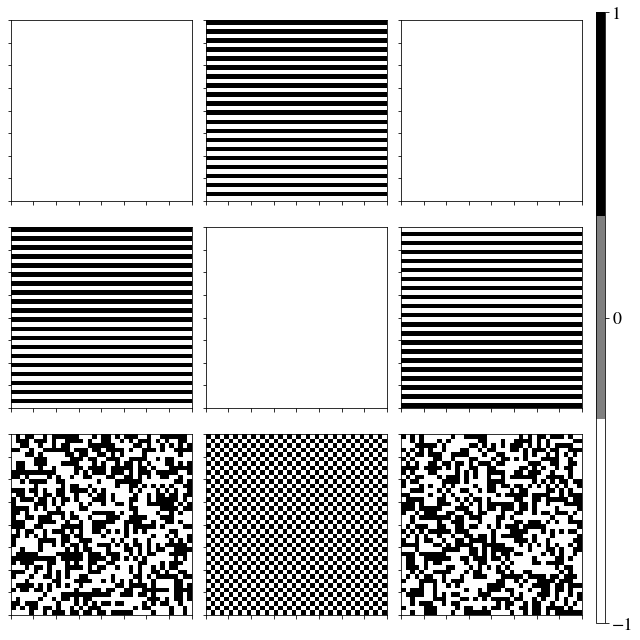

In [30]:
# Random graphs to show how to plot them

lattices_to_graph = [train_images[10 * i].reshape((L, L)) for i in range(9)]

auxLib.latticeGraph(lattices_to_graph, L)

# Neural Network

In [31]:
# Generate DNN models

for neuron in tqdm(neurons, desc=f"Generating DNN models", unit="neuron"):
    np.random.seed(seed)
    if neuron==1 or neuron==2:
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    else:   
        kernel_regularizer=tf.keras.regularizers.l2(0.01)

    dnn = auxLib.DenseNeuralNetworkGen() # Initializing. It generates the model

    dnn.build_model((L*L,), num_classes=4, layers=[
    {'type': 'dense', 'units': neuron, 'activation': 'relu', 'kernel_regularizer': kernel_regularizer},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 4, 'activation': 'softmax'}
    ])

    dnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    dnn.summary()

    dnn.fit(train_images, train_labels, 
            epochs=50, batch_size=20,
            validation_data=(test_images, test_labels), 
            callbacks=[callbacks],
            verbose=False)
    
    dnn.save_weights(f'dnn_{training}_n{neuron}_DO02', directory=modelsfolder) # name of the model (exclude the 'weights' and the extension)
    dnn.save_model(f'dnn_{training}_n{neuron}_DO02', directory=modelsfolder)

Generating DNN models:   0%|          | 0/33 [00:00<?, ?neuron/s]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 1601      
                                                                 
 dropout_3 (Dropout)         (None, 1)                 0         
                                                                 
 dense_7 (Dense)             (None, 4)                 8         
                                                                 
Total params: 1609 (6.29 KB)
Trainable params: 1609 (6.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\Usuario\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
Generating DNN models:   3%|▎         | 1/33 [01:00<32:17, 60.55s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n1_DO02.h5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 2)                 3202      
                                                                 
 dropout_4 (Dropout)         (None, 2)                 0         
                                                                 
 dense_9 (Dense)             (None, 4)                 12        
                                                                 
Total params: 3214 (12.55 KB)
Trainable params: 3214 (12.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:   6%|▌         | 2/33 [01:50<28:12, 54.58s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n2_DO02.h5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 3)                 4803      
                                                                 
 dropout_5 (Dropout)         (None, 3)                 0         
                                                                 
 dense_11 (Dense)            (None, 4)                 16        
                                                                 
Total params: 4819 (18.82 KB)
Trainable params: 4819 (18.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:   9%|▉         | 3/33 [02:44<27:06, 54.22s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n3_DO02.h5
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4)                 6404      
                                                                 
 dropout_6 (Dropout)         (None, 4)                 0         
                                                                 
 dense_13 (Dense)            (None, 4)                 20        
                                                                 
Total params: 6424 (25.09 KB)
Trainable params: 6424 (25.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  12%|█▏        | 4/33 [03:46<27:33, 57.02s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n4_DO02.h5
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 5)                 8005      
                                                                 
 dropout_7 (Dropout)         (None, 5)                 0         
                                                                 
 dense_15 (Dense)            (None, 4)                 24        
                                                                 
Total params: 8029 (31.36 KB)
Trainable params: 8029 (31.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  15%|█▌        | 5/33 [04:39<25:55, 55.57s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n5_DO02.h5
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 6)                 9606      
                                                                 
 dropout_8 (Dropout)         (None, 6)                 0         
                                                                 
 dense_17 (Dense)            (None, 4)                 28        
                                                                 
Total params: 9634 (37.63 KB)
Trainable params: 9634 (37.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  18%|█▊        | 6/33 [04:54<18:47, 41.76s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n6_DO02.h5
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 7)                 11207     
                                                                 
 dropout_9 (Dropout)         (None, 7)                 0         
                                                                 
 dense_19 (Dense)            (None, 4)                 32        
                                                                 
Total params: 11239 (43.90 KB)
Trainable params: 11239 (43.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  21%|██        | 7/33 [05:50<20:10, 46.55s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n7_DO02.h5
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 12808     
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 4)                 36        
                                                                 
Total params: 12844 (50.17 KB)
Trainable params: 12844 (50.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  24%|██▍       | 8/33 [06:40<19:49, 47.56s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n8_DO02.h5
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 9)                 14409     
                                                                 
 dropout_11 (Dropout)        (None, 9)                 0         
                                                                 
 dense_23 (Dense)            (None, 4)                 40        
                                                                 
Total params: 14449 (56.44 KB)
Trainable params: 14449 (56.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  27%|██▋       | 9/33 [06:43<13:28, 33.70s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n9_DO02.h5
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                16010     
                                                                 
 dropout_12 (Dropout)        (None, 10)                0         
                                                                 
 dense_25 (Dense)            (None, 4)                 44        
                                                                 
Total params: 16054 (62.71 KB)
Trainable params: 16054 (62.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  30%|███       | 10/33 [06:49<09:38, 25.17s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n10_DO02.h5
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 20)                32020     
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_27 (Dense)            (None, 4)                 84        
                                                                 
Total params: 32104 (125.41 KB)
Trainable params: 32104 (125.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  33%|███▎      | 11/33 [06:52<06:46, 18.50s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n20_DO02.h5
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 40)                64040     
                                                                 
 dropout_14 (Dropout)        (None, 40)                0         
                                                                 
 dense_29 (Dense)            (None, 4)                 164       
                                                                 
Total params: 64204 (250.80 KB)
Trainable params: 64204 (250.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  36%|███▋      | 12/33 [06:57<05:02, 14.39s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n40_DO02.h5
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 60)                96060     
                                                                 
 dropout_15 (Dropout)        (None, 60)                0         
                                                                 
 dense_31 (Dense)            (None, 4)                 244       
                                                                 
Total params: 96304 (376.19 KB)
Trainable params: 96304 (376.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  39%|███▉      | 13/33 [07:03<03:53, 11.66s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n60_DO02.h5
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 80)                128080    
                                                                 
 dropout_16 (Dropout)        (None, 80)                0         
                                                                 
 dense_33 (Dense)            (None, 4)                 324       
                                                                 
Total params: 128404 (501.58 KB)
Trainable params: 128404 (501.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  42%|████▏     | 14/33 [07:05<02:49,  8.92s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n80_DO02.h5
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 100)               160100    
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_35 (Dense)            (None, 4)                 404       
                                                                 
Total params: 160504 (626.97 KB)
Trainable params: 160504 (626.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  45%|████▌     | 15/33 [07:12<02:30,  8.33s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n100_DO02.h5
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 150)               240150    
                                                                 
 dropout_18 (Dropout)        (None, 150)               0         
                                                                 
 dense_37 (Dense)            (None, 4)                 604       
                                                                 
Total params: 240754 (940.45 KB)
Trainable params: 240754 (940.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  48%|████▊     | 16/33 [07:16<01:59,  7.04s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n150_DO02.h5
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 200)               320200    
                                                                 
 dropout_19 (Dropout)        (None, 200)               0         
                                                                 
 dense_39 (Dense)            (None, 4)                 804       
                                                                 
Total params: 321004 (1.22 MB)
Trainable params: 321004 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  52%|█████▏    | 17/33 [07:28<02:13,  8.32s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n200_DO02.h5
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 250)               400250    
                                                                 
 dropout_20 (Dropout)        (None, 250)               0         
                                                                 
 dense_41 (Dense)            (None, 4)                 1004      
                                                                 
Total params: 401254 (1.53 MB)
Trainable params: 401254 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Accuracy is high enough, so cancelling training!


Generating DNN models:  55%|█████▍    | 18/33 [07:51<03:11, 12.77s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n250_DO02.h5
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 300)               480300    
                                                                 
 dropout_21 (Dropout)        (None, 300)               0         
                                                                 
 dense_43 (Dense)            (None, 4)                 1204      
                                                                 
Total params: 481504 (1.84 MB)
Trainable params: 481504 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  58%|█████▊    | 19/33 [08:05<03:04, 13.18s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n300_DO02.h5
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 350)               560350    
                                                                 
 dropout_22 (Dropout)        (None, 350)               0         
                                                                 
 dense_45 (Dense)            (None, 4)                 1404      
                                                                 
Total params: 561754 (2.14 MB)
Trainable params: 561754 (2.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  61%|██████    | 20/33 [08:26<03:23, 15.62s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n350_DO02.h5
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 400)               640400    
                                                                 
 dropout_23 (Dropout)        (None, 400)               0         
                                                                 
 dense_47 (Dense)            (None, 4)                 1604      
                                                                 
Total params: 642004 (2.45 MB)
Trainable params: 642004 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Accuracy is high enough, so cancelling training!


Generating DNN models:  64%|██████▎   | 21/33 [08:44<03:16, 16.38s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n400_DO02.h5
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 450)               720450    
                                                                 
 dropout_24 (Dropout)        (None, 450)               0         
                                                                 
 dense_49 (Dense)            (None, 4)                 1804      
                                                                 
Total params: 722254 (2.76 MB)
Trainable params: 722254 (2.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Accuracy is high enough, so cancelling training!


Generating DNN models:  67%|██████▋   | 22/33 [09:15<03:46, 20.59s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n450_DO02.h5
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 500)               800500    
                                                                 
 dropout_25 (Dropout)        (None, 500)               0         
                                                                 
 dense_51 (Dense)            (None, 4)                 2004      
                                                                 
Total params: 802504 (3.06 MB)
Trainable params: 802504 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Accuracy is high enough, so cancelling training!


Generating DNN models:  70%|██████▉   | 23/33 [09:50<04:09, 24.91s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n500_DO02.h5
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 550)               880550    
                                                                 
 dropout_26 (Dropout)        (None, 550)               0         
                                                                 
 dense_53 (Dense)            (None, 4)                 2204      
                                                                 
Total params: 882754 (3.37 MB)
Trainable params: 882754 (3.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  73%|███████▎  | 24/33 [10:14<03:41, 24.66s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n550_DO02.h5
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 600)               960600    
                                                                 
 dropout_27 (Dropout)        (None, 600)               0         
                                                                 
 dense_55 (Dense)            (None, 4)                 2404      
                                                                 
Total params: 963004 (3.67 MB)
Trainable params: 963004 (3.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Accuracy is high enough, so cancelling training!


Generating DNN models:  76%|███████▌  | 25/33 [10:53<03:51, 28.88s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n600_DO02.h5
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 650)               1040650   
                                                                 
 dropout_28 (Dropout)        (None, 650)               0         
                                                                 
 dense_57 (Dense)            (None, 4)                 2604      
                                                                 
Total params: 1043254 (3.98 MB)
Trainable params: 1043254 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  79%|███████▉  | 26/33 [11:07<02:52, 24.65s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n650_DO02.h5
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 700)               1120700   
                                                                 
 dropout_29 (Dropout)        (None, 700)               0         
                                                                 
 dense_59 (Dense)            (None, 4)                 2804      
                                                                 
Total params: 1123504 (4.29 MB)
Trainable params: 1123504 (4.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  82%|████████▏ | 27/33 [11:23<02:11, 21.88s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n700_DO02.h5
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 750)               1200750   
                                                                 
 dropout_30 (Dropout)        (None, 750)               0         
                                                                 
 dense_61 (Dense)            (None, 4)                 3004      
                                                                 
Total params: 1203754 (4.59 MB)
Trainable params: 1203754 (4.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  85%|████████▍ | 28/33 [11:40<01:42, 20.43s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n750_DO02.h5
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 800)               1280800   
                                                                 
 dropout_31 (Dropout)        (None, 800)               0         
                                                                 
 dense_63 (Dense)            (None, 4)                 3204      
                                                                 
Total params: 1284004 (4.90 MB)
Trainable params: 1284004 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Accuracy is high enough, so cancelling training!


Generating DNN models:  88%|████████▊ | 29/33 [12:17<01:41, 25.42s/neuron]

Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n800_DO02.h5
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 850)               1360850   
                                                                 
 dropout_32 (Dropout)        (None, 850)               0         
                                                                 
 dense_65 (Dense)            (None, 4)                 3404      
                                                                 
Total params: 1364254 (5.20 MB)
Trainable params: 1364254 (5.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  91%|█████████ | 30/33 [12:36<01:10, 23.43s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n850_DO02.h5
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 900)               1440900   
                                                                 
 dropout_33 (Dropout)        (None, 900)               0         
                                                                 
 dense_67 (Dense)            (None, 4)                 3604      
                                                                 
Total params: 1444504 (5.51 MB)
Trainable params: 1444504 (5.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  94%|█████████▍| 31/33 [12:55<00:44, 22.32s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n900_DO02.h5
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 950)               1520950   
                                                                 
 dropout_34 (Dropout)        (None, 950)               0         
                                                                 
 dense_69 (Dense)            (None, 4)                 3804      
                                                                 
Total params: 1524754 (5.82 MB)
Trainable params: 1524754 (5.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models:  97%|█████████▋| 32/33 [13:18<00:22, 22.32s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n950_DO02.h5
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 1000)              1601000   
                                                                 
 dropout_35 (Dropout)        (None, 1000)              0         
                                                                 
 dense_71 (Dense)            (None, 4)                 4004      
                                                                 
Total params: 1605004 (6.12 MB)
Trainable params: 1605004 (6.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Generating DNN models: 100%|██████████| 33/33 [13:39<00:00, 24.84s/neuron]


Accuracy is high enough, so cancelling training!
Model saved as d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n1000_DO02.h5


In [32]:
# Initialize the DenseNeuralNetworkGen instance
dnn = auxLib.DenseNeuralNetworkGen()

training = 'all'
# Load the model
dnn.load_model(f'dnn_{training}_n2_DO02', directory=modelsfolder)

# Load the weights
dnn.load_weights(f'dnn_{training}_n2_DO02', directory=modelsfolder)  # Load the weights directly on the same instance

Model "dnn_all_n2_DO02" correctly loaded from d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n2_DO02.h5
Weights of the model "dnn_all_n2_DO02" correctly loaded from d:\Facultad\Doctorado\Proyectos\paper\DNN\All\models\2024-08-18\dnn_all_n2_DO02_weights.h5


# Loading simulated images to test the NN

In [33]:
# Initializing loader and saver

loader_init = auxLib.loader_and_saver(os.getcwd())

# Loading simulated images

sim_images, temperature = loader_init.simulatedImages(-1)


Loading simulated images...


Loading arrays: 100%|██████████| 156/156 [00:02<00:00, 63.53array/s]

Files loaded!
Data of density p = 1. succesfully loaded.


Predicting: 100%|██████████| 155/155 [00:16<00:00,  9.20repetitions/s]


Prediction for 1 neurons in hidden layer
T_c = 0


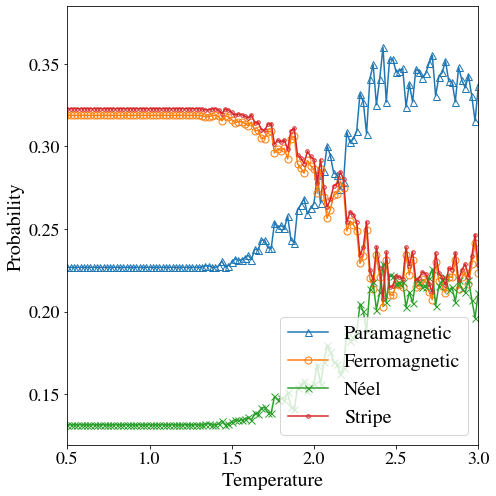

Predicting: 100%|██████████| 155/155 [00:13<00:00, 11.38repetitions/s]


Prediction for 2 neurons in hidden layer
T_c = 2.2434999790373893


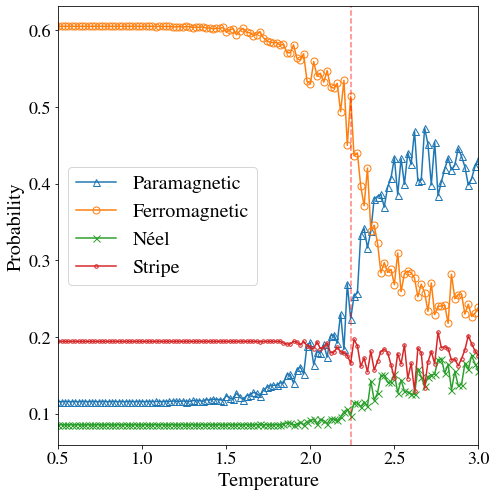

Predicting: 100%|██████████| 155/155 [00:15<00:00, 10.22repetitions/s]


Prediction for 3 neurons in hidden layer
T_c = 0


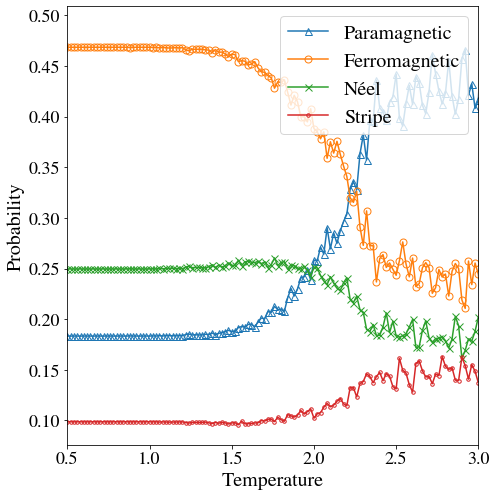

Predicting: 100%|██████████| 155/155 [00:15<00:00, 10.18repetitions/s]


Prediction for 4 neurons in hidden layer
T_c = 2.435438850296269


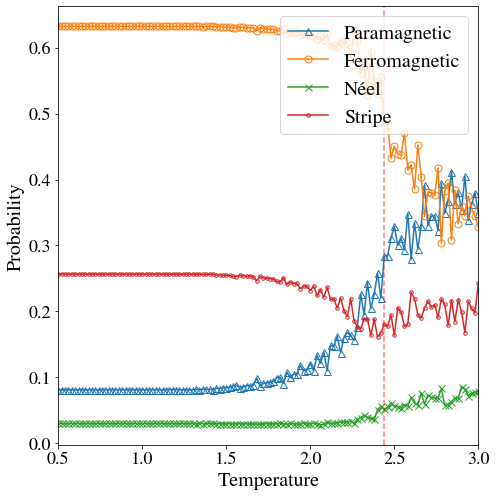

Predicting: 100%|██████████| 155/155 [00:13<00:00, 11.52repetitions/s]


Prediction for 5 neurons in hidden layer
T_c = 2.3179409200142724


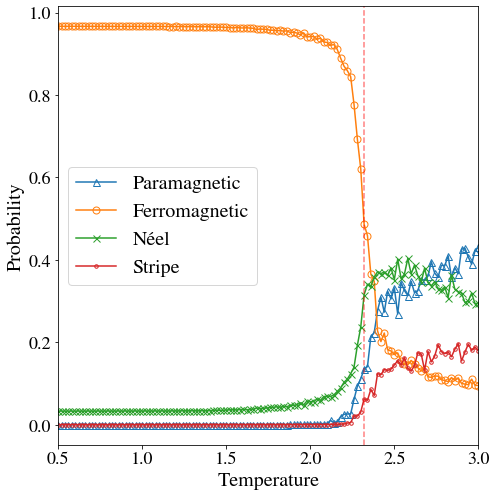

Predicting: 100%|██████████| 155/155 [00:14<00:00, 10.66repetitions/s]


Prediction for 6 neurons in hidden layer
T_c = 2.38143737879752


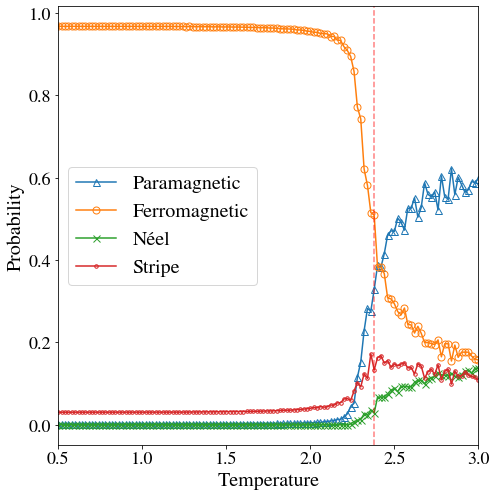

Predicting: 100%|██████████| 155/155 [00:12<00:00, 12.38repetitions/s]


Prediction for 7 neurons in hidden layer
T_c = 2.3570012068144455


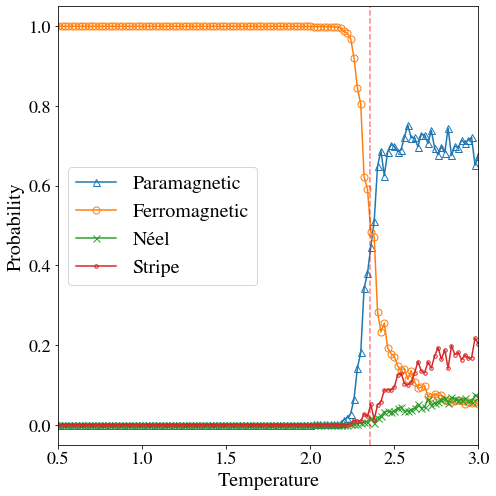

Predicting: 100%|██████████| 155/155 [00:12<00:00, 12.23repetitions/s]


Prediction for 8 neurons in hidden layer
T_c = 2.3592952081045775


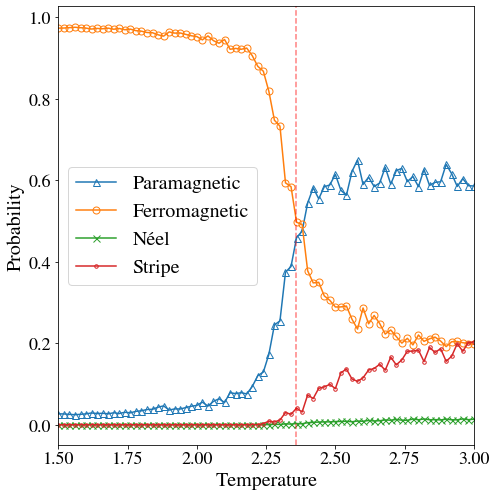

Predicting: 100%|██████████| 155/155 [00:20<00:00,  7.53repetitions/s]


Prediction for 9 neurons in hidden layer
T_c = 2.389893767775511


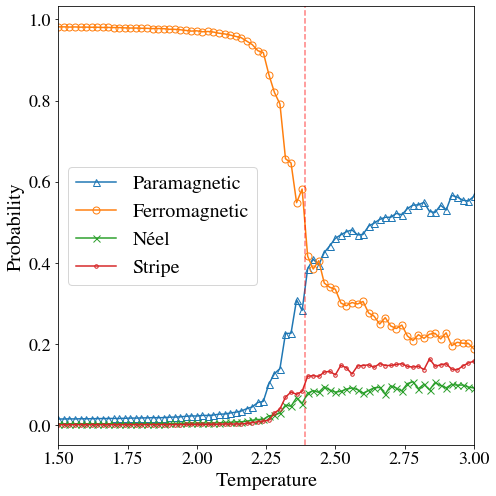

Predicting: 100%|██████████| 155/155 [00:12<00:00, 12.63repetitions/s]


Prediction for 10 neurons in hidden layer
T_c = 2.3953663797732667


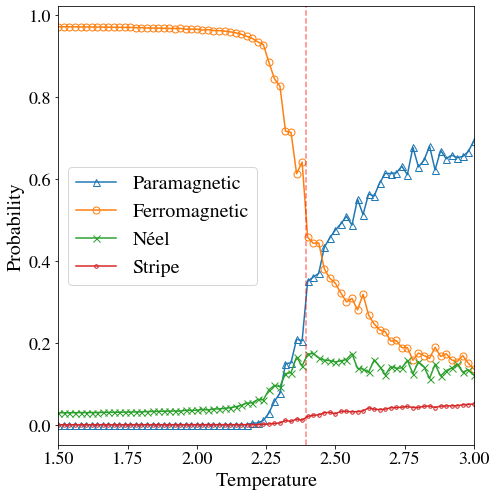

Predicting: 100%|██████████| 155/155 [00:19<00:00,  7.86repetitions/s]


Prediction for 20 neurons in hidden layer
T_c = 2.4407647760249334


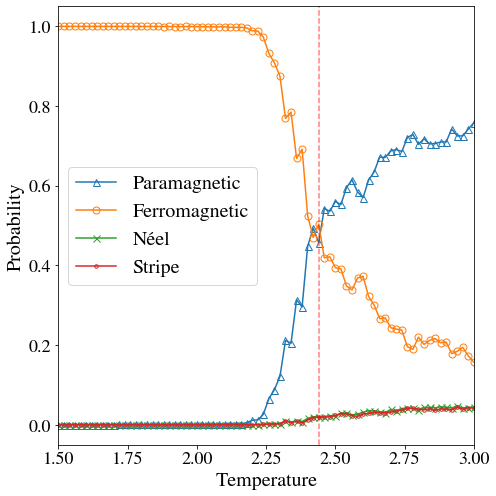

Predicting: 100%|██████████| 155/155 [00:17<00:00,  8.86repetitions/s]


Prediction for 40 neurons in hidden layer
T_c = 2.392013642505495


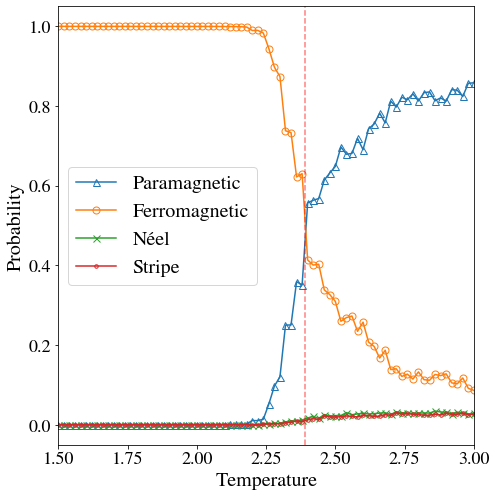

Predicting: 100%|██████████| 155/155 [00:18<00:00,  8.23repetitions/s]


Prediction for 60 neurons in hidden layer
T_c = 2.620849996230682


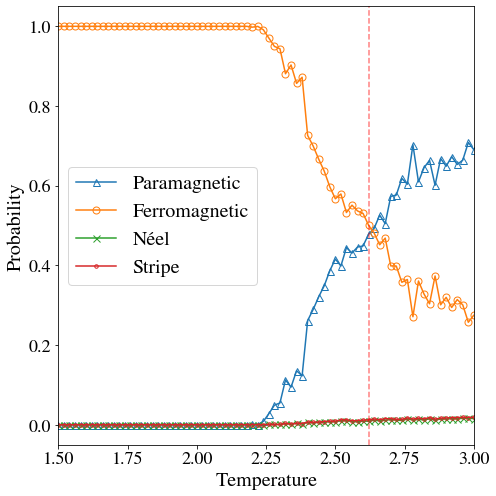

Predicting: 100%|██████████| 155/155 [00:22<00:00,  6.92repetitions/s]


Prediction for 80 neurons in hidden layer
T_c = 2.353254625521249


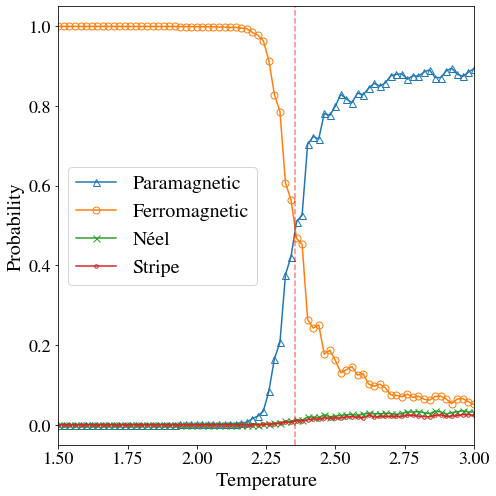

Predicting: 100%|██████████| 155/155 [00:14<00:00, 10.81repetitions/s]


Prediction for 100 neurons in hidden layer
T_c = 2.3325375727564936


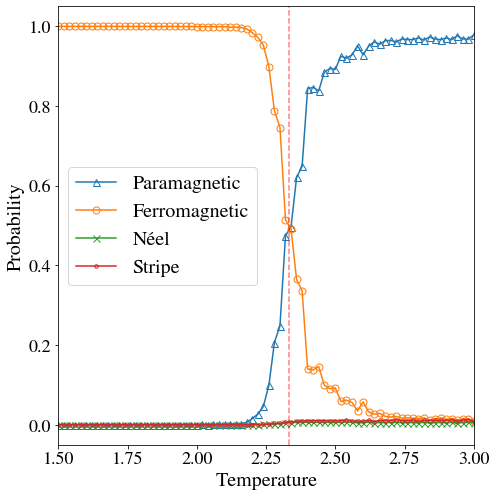

Predicting: 100%|██████████| 155/155 [00:16<00:00,  9.45repetitions/s]


Prediction for 150 neurons in hidden layer
T_c = 2.487721563944049


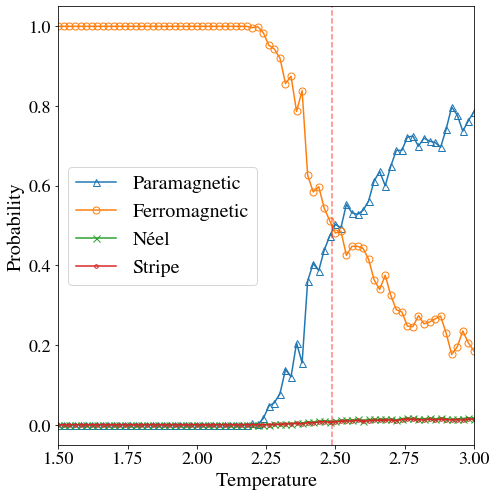

Predicting: 100%|██████████| 155/155 [00:21<00:00,  7.09repetitions/s]


Prediction for 200 neurons in hidden layer
T_c = 2.356319549557817


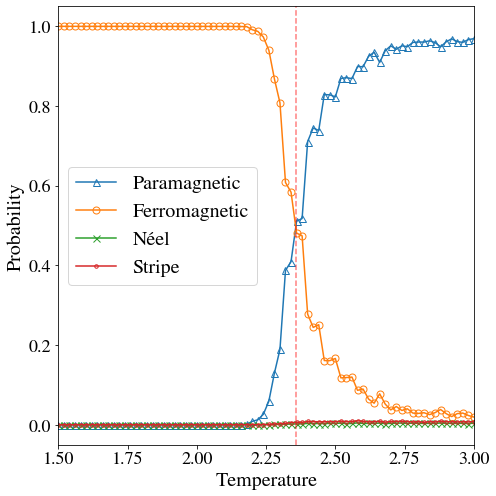

Predicting: 100%|██████████| 155/155 [00:22<00:00,  6.81repetitions/s]


Prediction for 250 neurons in hidden layer
T_c = 2.322672170086219


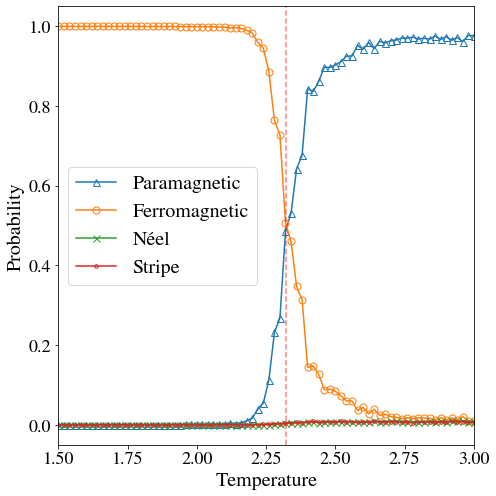

Predicting: 100%|██████████| 155/155 [00:20<00:00,  7.73repetitions/s]


Prediction for 300 neurons in hidden layer
T_c = 2.3835494849723506


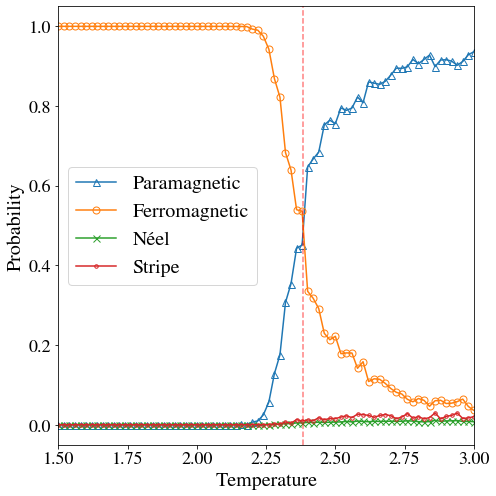

Predicting: 100%|██████████| 155/155 [00:24<00:00,  6.20repetitions/s]


Prediction for 350 neurons in hidden layer
T_c = 2.3402433197135024


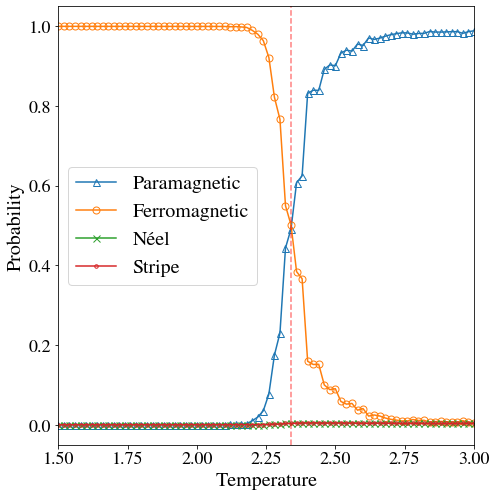

Predicting: 100%|██████████| 155/155 [00:17<00:00,  8.71repetitions/s]


Prediction for 400 neurons in hidden layer
T_c = 2.3598217263703694


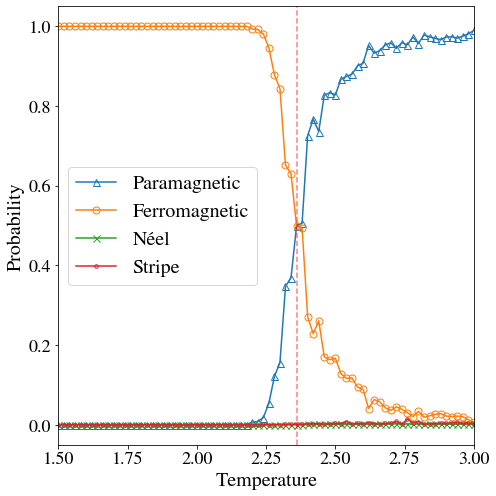

Predicting: 100%|██████████| 155/155 [00:18<00:00,  8.40repetitions/s]


Prediction for 450 neurons in hidden layer
T_c = 2.311869318845884


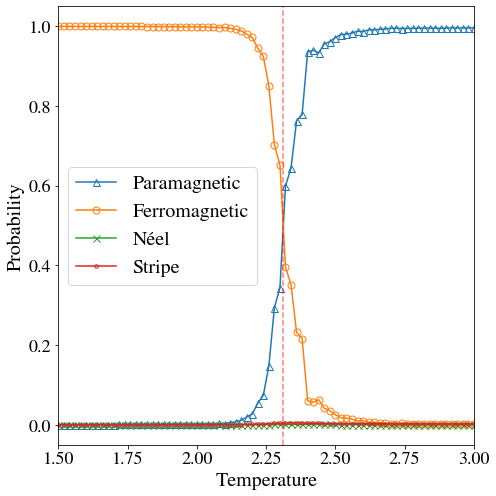

Predicting: 100%|██████████| 155/155 [00:20<00:00,  7.61repetitions/s]


Prediction for 500 neurons in hidden layer
T_c = 2.303955986529728


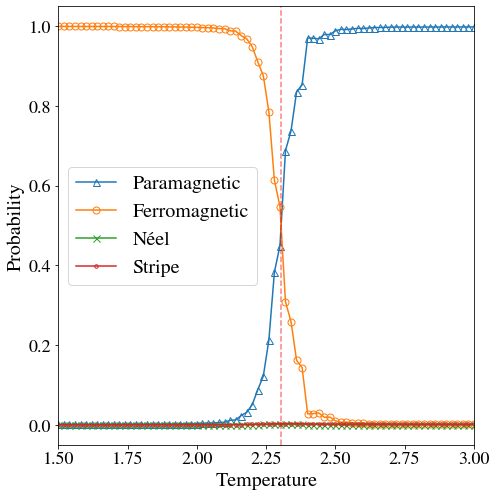

Predicting: 100%|██████████| 155/155 [00:16<00:00,  9.16repetitions/s]


Prediction for 550 neurons in hidden layer
T_c = 2.31263125512892


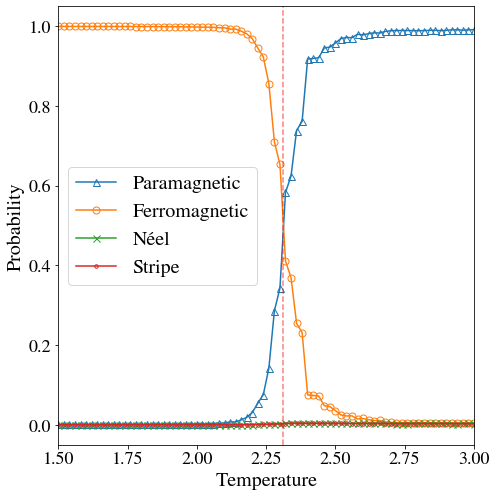

Predicting: 100%|██████████| 155/155 [01:04<00:00,  2.42repetitions/s]


Prediction for 600 neurons in hidden layer
T_c = 2.3079950466114876


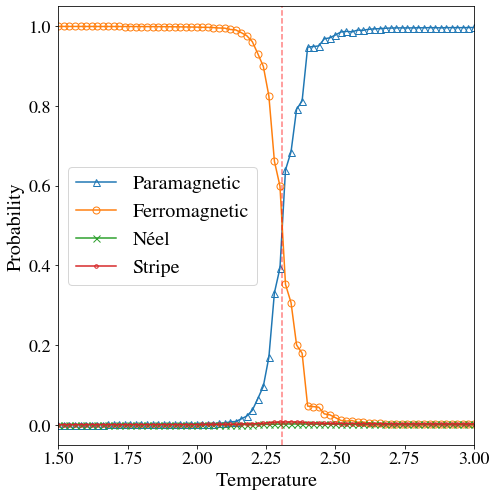

Predicting: 100%|██████████| 155/155 [00:26<00:00,  5.87repetitions/s]


Prediction for 650 neurons in hidden layer
T_c = 2.3122855395032973


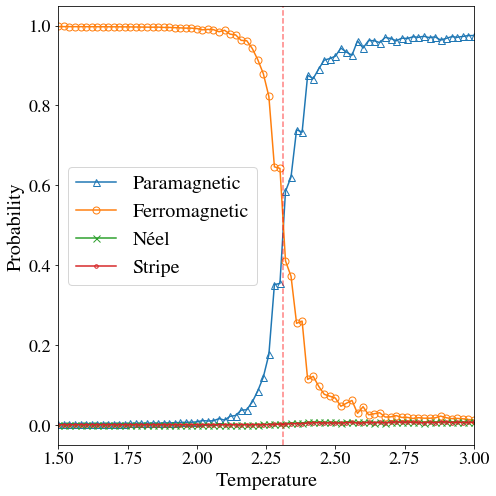

Predicting: 100%|██████████| 155/155 [00:19<00:00,  7.79repetitions/s]


Prediction for 700 neurons in hidden layer
T_c = 2.3138039698403516


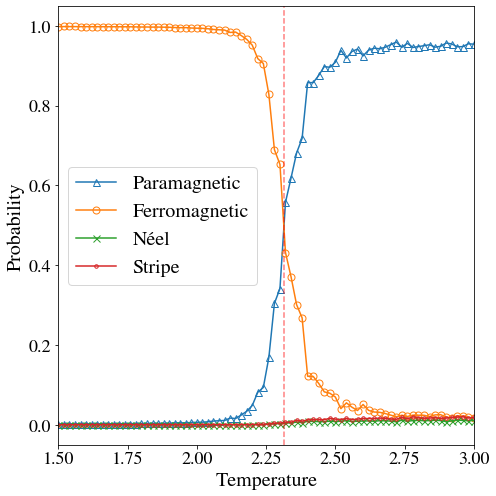

Predicting: 100%|██████████| 155/155 [00:21<00:00,  7.22repetitions/s]


Prediction for 750 neurons in hidden layer
T_c = 2.313269752152488


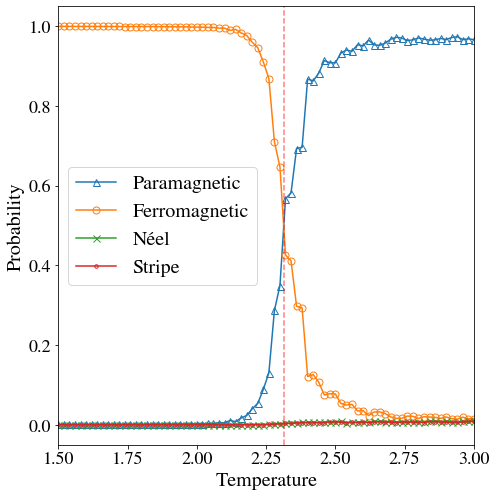

Predicting: 100%|██████████| 155/155 [00:19<00:00,  7.90repetitions/s]


Prediction for 800 neurons in hidden layer
T_c = 2.305074173536431


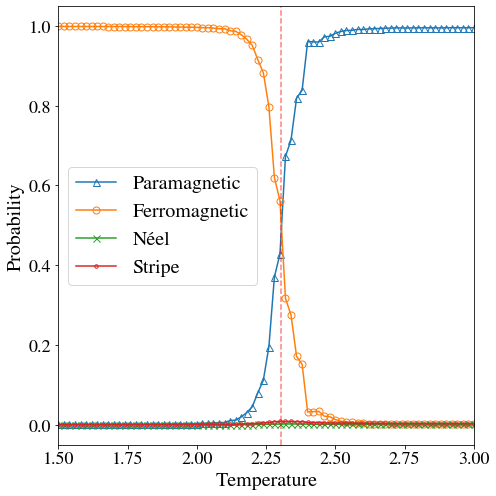

Predicting: 100%|██████████| 155/155 [00:20<00:00,  7.67repetitions/s]


Prediction for 850 neurons in hidden layer
T_c = 2.3098356965014104


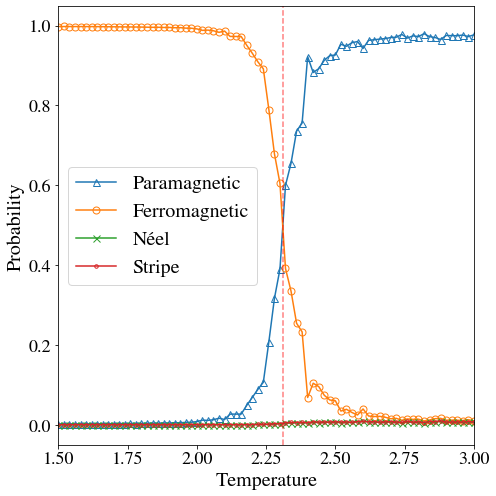

Predicting: 100%|██████████| 155/155 [00:20<00:00,  7.40repetitions/s]


Prediction for 900 neurons in hidden layer
T_c = 2.305756326300096


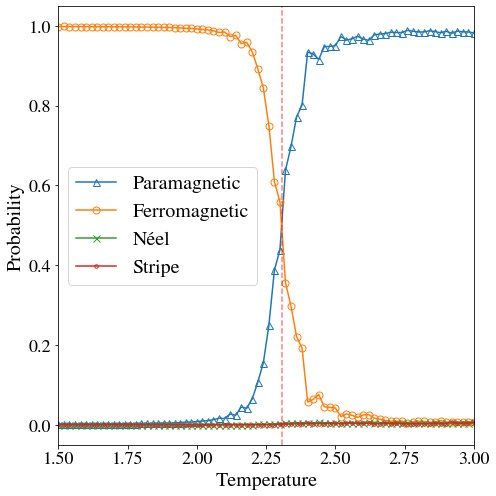

Predicting: 100%|██████████| 155/155 [00:23<00:00,  6.65repetitions/s]


Prediction for 950 neurons in hidden layer
T_c = 2.3068559398052666


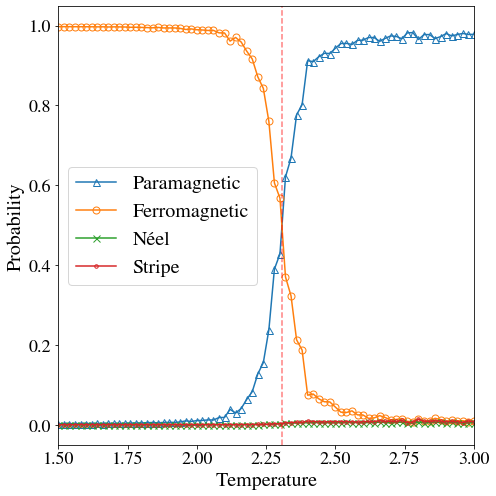

Predicting: 100%|██████████| 155/155 [00:22<00:00,  6.97repetitions/s]


Prediction for 1000 neurons in hidden layer
T_c = 2.307445440636632


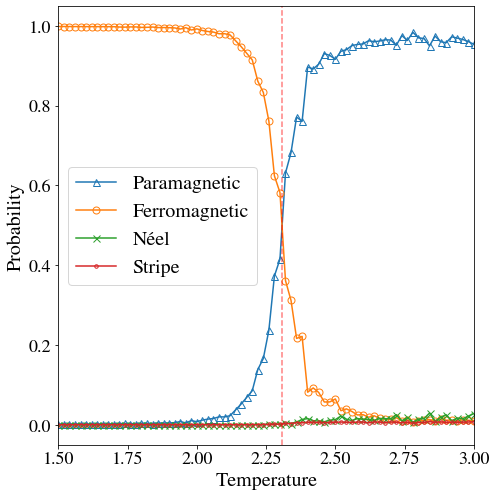

In [34]:
critical_temperatures = []

training = 'all'

for neuron in neurons:
    index = neurons.index(neuron)

    model_path = os.path.join(modelsfolder, f'dnn_{training}_n{neuron}_DO02.h5')

    dnn = keras.models.load_model(model_path)

    prediction = auxLib.predictor(L, dnn, sim_images, neuron, 
                                training=['para', 'ferro', 'neel', 'stripe'],
                                directory=resultsfolder, 
                                reshape = True, 
                                verbose=False, 
                                save_prediction=True)

    para, ferro, neel, stripe = prediction.T

    print(f'Prediction for {neuron} neurons in hidden layer')

    plt.figure(figsize=(7, 7))
    plt.plot(temperature, para, '^-', label='Paramagnetic', markerfacecolor='none', markersize=7)
    plt.plot(temperature, ferro, 'o-', label='Ferromagnetic', markerfacecolor='none', markersize=7)
    plt.plot(temperature, neel, 'x-', label='Néel', markerfacecolor='none', markersize=7)
    plt.plot(temperature, stripe, '.-', label='Stripe', markerfacecolor='none', markersize=7)
    
    if neuron<8:
        plt.xlim((0.5, 3))
    else:
        plt.xlim((1.5, 3))
    plt.xlabel('Temperature')
    plt.ylabel('Probability')
    plt.legend()

    if max(ferro)<0.5:
        tc = 0
    else:
        index_half = np.where(ferro > 0.5)[0][-1]
        # Interpolation:
        tc = temperature[index_half] + (ferro[index_half]-0.5)*(temperature[index_half+1] - temperature[index_half]) / (ferro[index_half] - ferro[index_half+1])
        plt.axvline(x=tc,  color = 'red', linestyle = '--', alpha = 0.5)

    critical_temperatures.append(tc)
    print(f'T_c = {tc}')
    plt.savefig(os.path.join(resultsfolder, f'{training}_{neuron}neurons.pdf'))
    plt.show()

# Transition temperatures

In [35]:
critical_temperatures

[0,
 2.2434999790373893,
 0,
 2.435438850296269,
 2.3179409200142724,
 2.38143737879752,
 2.3570012068144455,
 2.3592952081045775,
 2.389893767775511,
 2.3953663797732667,
 2.4407647760249334,
 2.392013642505495,
 2.620849996230682,
 2.353254625521249,
 2.3325375727564936,
 2.487721563944049,
 2.356319549557817,
 2.322672170086219,
 2.3835494849723506,
 2.3402433197135024,
 2.3598217263703694,
 2.311869318845884,
 2.303955986529728,
 2.31263125512892,
 2.3079950466114876,
 2.3122855395032973,
 2.3138039698403516,
 2.313269752152488,
 2.305074173536431,
 2.3098356965014104,
 2.305756326300096,
 2.3068559398052666,
 2.307445440636632]

In [36]:
temp = pd.DataFrame((np.concatenate((np.array(neurons).reshape(len(neurons),1), 
                                    np.array(critical_temperatures).reshape(len(neurons),1)),axis=1)), 
                                    columns=['Neurons','Temperature'])
temp.to_csv(os.path.join(resultsfolder, 'critical_temperatures.csv'), index=False)

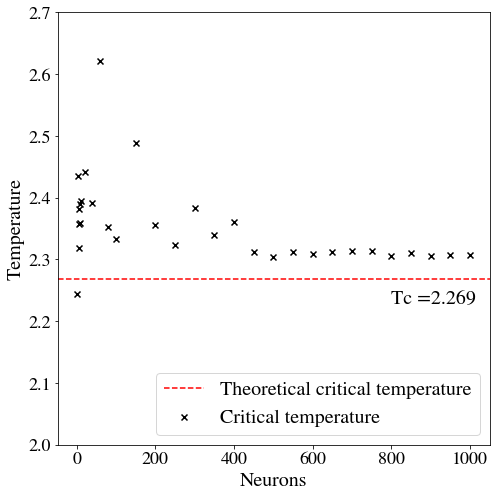

In [40]:
temp = pd.read_csv(os.path.join(resultsfolder, f'critical_temperatures.csv'))

plt.figure(figsize=(7, 7))
plt.scatter(temp['Neurons'][1:],temp['Temperature'][1:], marker='x', color='black', label='Critical temperature')
plt.axhline(y=2.269, color = 'red', linestyle = '--', label = 'Theoretical critical temperature')
plt.xlabel('Neurons')
plt.ylabel('Temperature')

plt.text(800, 2.25, rf'Tc ={2.269}', color='black', 
        verticalalignment='top', horizontalalignment='left', fontsize=20)

plt.ylim((2, 2.7))
plt.legend(loc='lower right')
plt.savefig(os.path.join(os.getcwd(), resultsfolder, 'critical_temperatures.pdf'))
plt.show()

# When talking about percolation

In [ ]:
datadf = {"Densidad":densities, "Temperatura":critical_temperatures}

temp_df = pd.DataFrame(datadf)

temp_df.to_csv(os.path.join(resultsfolder, 'temp_dnn_all.csv'), index=False)

densi = np.arange(0.0,1.002,0.002)
curva = densi*0
for i in range(len(densi)):
    if densi[i]<0.592746:
        curva[i] = 0
    elif densi[i]<0.89:
        curva[i] = -(0.983)/(np.log(densi[i]-0.592746))  
        last_i = i

for i in range(last_i, len(densi)):
     curva[i] = curva[last_i] + 1.7 * (densi[i]-densi[last_i])

#plt.figure(figsize=(10,7))
plt.plot(temp_df['Densidad'],temp_df['Temperatura']/2.269)#np.array(temp_df['Temperatura'])[-1],'x--')
plt.plot(densi,curva,'r')
plt.xlim(0.4,1)
plt.legend(temp_df.columns)
plt.show()